In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from dask import dataframe as dd

sns.set_theme(style="darkgrid")
current_palette = sns.color_palette()


In [2]:
pd.options.display.min_rows = 20
pd.options.display.max_columns = 500


### Load in the data

In [3]:
## Read in 2022 data from filesystem
chunk_df_flights = pd.read_csv("../../data/eda/flights/flight_data_Y2022/flight_data_2022.csv.zip", low_memory=False, chunksize=1000)

In [6]:
df_flights = pd.concat(chunk_df_flights, ignore_index=True)

In [7]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2802967 entries, 0 to 2802966
Columns: 121 entries, Unnamed: 0 to Unnamed: 119
dtypes: float64(72), int64(24), object(25)
memory usage: 2.5+ GB


In [8]:
df_flights = df_flights.rename(columns={"Operating_Airline ": "Operating_Airline", "Flight_Number_Operating_Airline": "Flight_Number"})

In [9]:
airlines = pd.read_csv(
    "../../data/databases/flight_attributes/airlines.csv.zip", low_memory=False)
airline_mapper = airlines.set_index("Code")["Description"]

In [10]:
cancellation_codes = pd.read_csv(
    "../../data/databases/flight_attributes/cancellation_codes.csv", low_memory=False)
cancellation_code_mapper = cancellation_codes.set_index(
    "CANCELLATION_REASON")["CANCELLATION_DESCRIPTION"]


In [11]:
usa_airports = (pd.read_csv("../../data/databases/flight_attributes/usa_airports.csv.zip",
                            usecols= ["iata","latitude","longitude"], 
                            low_memory=False))
usa_airports = usa_airports.rename(columns={"iata": "Origin"})
usa_airports.head()



,Origin,latitude,longitude
0,00M,31.953765,-89.234505
1,00R,30.685861,-95.017928
2,00V,38.945749,-104.569893
3,01G,42.741347,-78.052081
4,01J,30.688012,-81.905944


### Clean the data
- Handling missing values
- Feature Selection
- Encoding Categorical Variables
- Train - Test Split

In [ ]:
df_flights.shape

In [12]:
#df_flights.columns.to_list()
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2802967 entries, 0 to 2802966
Columns: 121 entries, Unnamed: 0 to Unnamed: 119
dtypes: float64(72), int64(24), object(25)
memory usage: 2.5+ GB


In [13]:
def airline_mapping(df_flights):
    df_flights["Operating_Airline"] = (
        df_flights["Operating_Airline"].map(airline_mapper))
    df_flights["CancellationCode"] = (
        df_flights["CancellationCode"].map(cancellation_code_mapper))
    return df_flights

def tweak_df_flights(df_flights):
    SELECTED_COLUMNS = ["FlightDate", "Operating_Airline", "Tail_Number", "Flight_Number", "OriginAirportID",
                        "Origin", "OriginCityName", "OriginState", "OriginStateName", "DestAirportID", "Dest", "DestCityName",
                        "DestState", "DestStateName", "CRSDepTime", "DepTime", "DepDelay", "DepDel15", "DepDelayMinutes", "DepTimeBlk",
                        "TaxiOut", "WheelsOn", "TaxiIn", "CRSArrTime", "ArrTime", "ArrDelayMinutes", "ArrDel15", "ArrTimeBlk",
                        "Cancelled", "CancellationCode", "Diverted", "CRSElapsedTime", "AirTime", "Distance", "CarrierDelay",
                        "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "FirstDepTime", "TotalAddGTime",
                        ]
    df_flights = (
        df_flights[SELECTED_COLUMNS]
        .copy()
    )
    df_flights = (pd.merge(df_flights, usa_airports, how="left", on=["Origin"]))
    df_flights.pipe(airline_mapping)
    return df_flights.assign(
        DepTime=df_flights.DepTime.fillna(0).astype("float16"),
        DepDelay=df_flights.DepDelay.fillna(0).astype("float16"),
        DepDel15=df_flights.DepDel15.fillna(0).astype("float16"),
        DepDelayMinutes=df_flights.DepDelayMinutes.fillna(0).astype("float16"),
        TaxiOut=df_flights.TaxiOut.fillna(0).astype("float16"),
        WheelsOn=df_flights.WheelsOn.fillna(0).astype("float16"),
        TaxiIn=df_flights.TaxiIn.fillna(0).astype("float16"),
        ArrDel15=df_flights.ArrDel15.fillna(0).astype("float16"),
        ArrDelayMinutes=df_flights.ArrDelayMinutes.fillna(0).astype("float16"),
        CRSElapsedTime=df_flights.CRSElapsedTime.fillna(0).astype("float16"),
        ArrTime=df_flights.ArrTime.fillna(0).astype("float16"),
        AirTime=df_flights.AirTime.fillna(0).astype("float16"),
        Distance=df_flights.Distance.fillna(0).astype("float16"),
        CarrierDelay=df_flights.CarrierDelay.fillna(0).astype("float16"),
        WeatherDelay=df_flights.WeatherDelay.fillna(0).astype("float16"),
        NASDelay=df_flights.NASDelay.fillna(0).astype("float16"),
        SecurityDelay=df_flights.SecurityDelay.fillna(0).astype("float16"),
        LateAircraftDelay=df_flights.LateAircraftDelay.fillna(
            0).astype("float16"),
        FirstDepTime=df_flights.FirstDepTime.fillna(0).astype("float16"),
        TotalAddGTime=df_flights.TotalAddGTime.fillna(0).astype("float16"),
        CancellationCode=df_flights.CancellationCode.fillna(
            "none").astype("category"),
        Tail_Number=df_flights.Tail_Number.fillna("none").astype("category"),
        FlightDate=dd.to_datetime(df_flights.FlightDate)
    ).astype(
        {
            "Operating_Airline": "category",
            "Origin": "category",
            "Dest": "category",
            "DestState": "category",
            "OriginState": "category",
            "OriginCityName": "category",
            "OriginStateName": "category",
            "DestStateName": "category",
            "DestCityName": "category",
            "DepTimeBlk": "category",
            "ArrTimeBlk": "category",
            "Cancelled": "bool",
            "Diverted": "bool",
            "OriginAirportID": "int16",
            "DestAirportID": "int16",
            "CRSDepTime": "int16",
            "CRSArrTime": "int16",
            "Flight_Number": "int16"
        }
    )


df_flights = tweak_df_flights(df_flights)
df_flights.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2802967 entries, 0 to 2802966
Data columns (total 43 columns):
 #   Column             Dtype         
---  ------             -----         
 0   FlightDate         datetime64[ns]
 1   Operating_Airline  category      
 2   Tail_Number        category      
 3   Flight_Number      int16         
 4   OriginAirportID    int16         
 5   Origin             category      
 6   OriginCityName     category      
 7   OriginState        category      
 8   OriginStateName    category      
 9   DestAirportID      int16         
 10  Dest               category      
 11  DestCityName       category      
 12  DestState          category      
 13  DestStateName      category      
 14  CRSDepTime         int16         
 15  DepTime            float16       
 16  DepDelay           float16       
 17  DepDel15           float16       
 18  DepDelayMinutes    float16       
 19  DepTimeBlk         category      
 20  TaxiOut            float

In [14]:
## save flight data to db

In [15]:
df_flights.shape


(2802967, 43)

In [16]:
df_flights.columns.to_list()

['FlightDate',
 'Operating_Airline',
 'Tail_Number',
 'Flight_Number',
 'OriginAirportID',
 'Origin',
 'OriginCityName',
 'OriginState',
 'OriginStateName',
 'DestAirportID',
 'Dest',
 'DestCityName',
 'DestState',
 'DestStateName',
 'CRSDepTime',
 'DepTime',
 'DepDelay',
 'DepDel15',
 'DepDelayMinutes',
 'DepTimeBlk',
 'TaxiOut',
 'WheelsOn',
 'TaxiIn',
 'CRSArrTime',
 'ArrTime',
 'ArrDelayMinutes',
 'ArrDel15',
 'ArrTimeBlk',
 'Cancelled',
 'CancellationCode',
 'Diverted',
 'CRSElapsedTime',
 'AirTime',
 'Distance',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay',
 'FirstDepTime',
 'TotalAddGTime',
 'latitude',
 'longitude']

## Statistical Analysis

<AxesSubplot: title={'center': 'Distribution of flight delays'}, xlabel='FlightDate'>

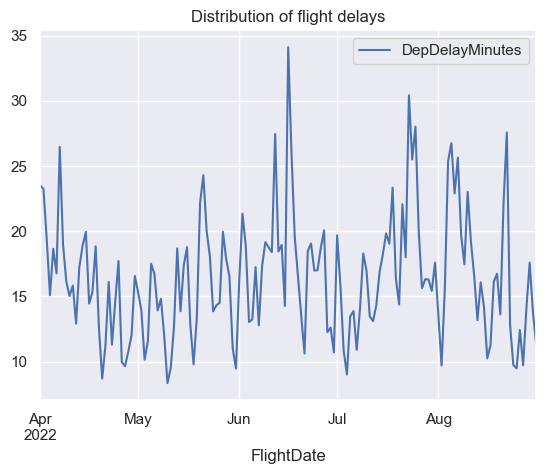

In [17]:
(df_flights
 .groupby("FlightDate")
 [["DepDelayMinutes"]]
 .mean()
 .plot(title="Distribution of flight delays"))


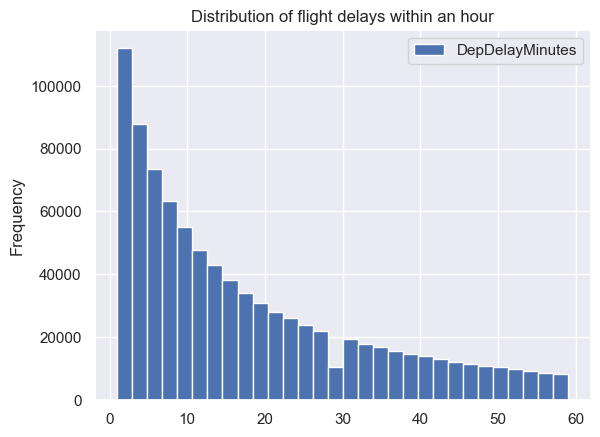

In [18]:
(df_flights
 .query("DepDelayMinutes > 0 and DepDelayMinutes < 60")
 [["DepDelayMinutes"]]
 .plot(kind="hist", bins=30, title="Distribution of flight delays within an hour"))
plt.show()


In [19]:
px.line(df_flights
        .groupby("FlightDate")
        [["DepDelayMinutes"]]
        .mean()
        )


#### Flight Status Categories

Departure Delay Groups

In [20]:
# Departure Delay intervals until 180 mins
def DepDelay_Class(df_flights):
    df_flights["DepDelayClass"] = None
    df_flights.loc[df_flights["DepDelayMinutes"] <= 15, "DepDelayClass"] = "OnTime"
    df_flights.loc[(df_flights["DepDelayMinutes"] > 15) & (df_flights["DepDelayMinutes"] <= 45), "DepDelayClass"] = "Delay15_45"
    df_flights.loc[(df_flights["DepDelayMinutes"] > 45), "DepDelayClass"] = "Delay45_180"
    df_flights.loc[df_flights["Cancelled"], "DepDelayClass"] = "Cancelled"
    
DepDelay_Class(df_flights)

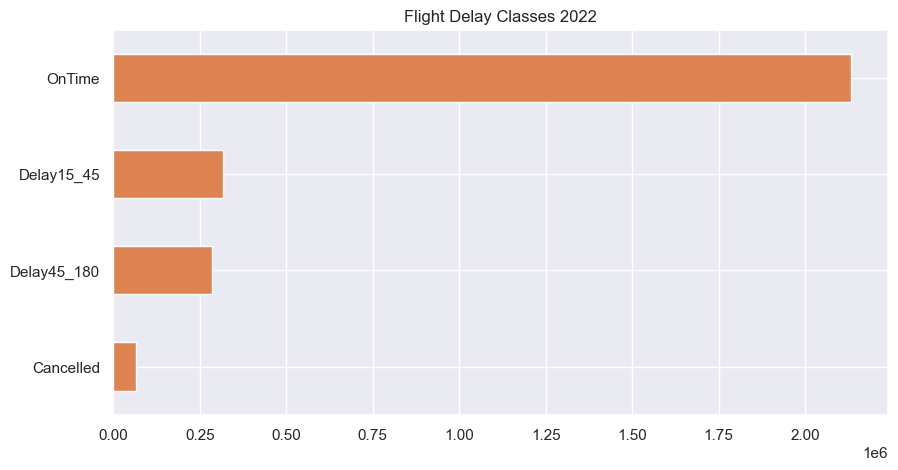

In [21]:
(df_flights
 .DepDelayClass
 .value_counts(ascending=True)
 .plot(kind='barh', figsize=(10,5), color=current_palette[1], title="Flight Delay Classes 2022")
 )
plt.show()

In [22]:
df_flights["DepDelayClass"].value_counts()/ df_flights.shape[0]

OnTime         0.761284
Delay15_45     0.112870
Delay45_180    0.102081
Cancelled      0.023764
Name: DepDelayClass, dtype: float64

In [23]:
df_flights["Year"] = df_flights["FlightDate"].dt.year
df_flights_agg = df_flights.groupby("Year")["DepDelayClass"].value_counts().unstack()
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Year,,,,
2022,66611,316371,286130,2133855


In [24]:
df_flights["Month"] = df_flights["FlightDate"].dt.month
df_flights_agg = df_flights.groupby("Month")["DepDelayClass"].value_counts().unstack()
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Month,,,,
4,9529,35437,35752,284803
5,11993,66334,53961,470662
6,18473,72997,65768,444819
7,11133,72804,67717,467136
8,15483,68799,62932,466435


Flights per month

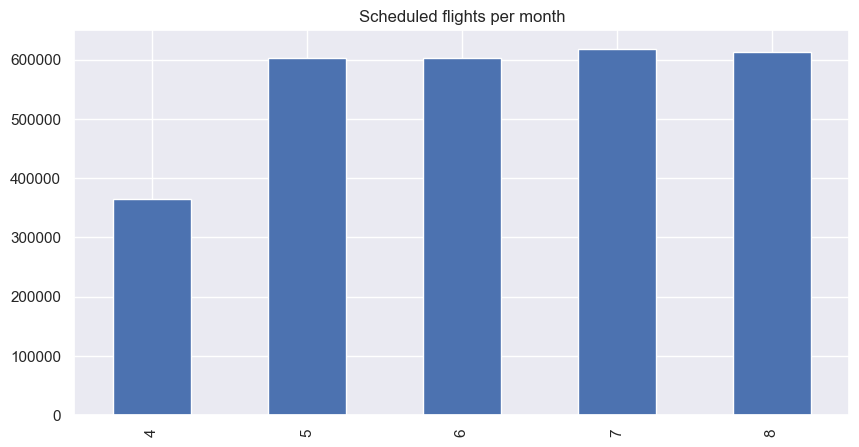

In [25]:
df_flights["Month"].value_counts().sort_index().plot(kind="bar", figsize=(10,5), title="Scheduled flights per month")
plt.show()

In [26]:
df_flights_agg.sum(axis=1)


Month
4    365521
5    602950
6    602057
7    618790
8    613649
dtype: int64

In [27]:
df_flights.head()

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,latitude,longitude,DepDelayClass,Year,Month
0,2022-04-05,American Airlines Inc.,N942AN,2700,11057,CLT,"Charlotte, NC",NC,North Carolina,13303,MIA,"Miami, FL",FL,Florida,1809,1829.0,20.0,1.0,20.0,1800-1859,24.0,2040.0,38.0,2015,2118.0,63.0,1.0,2000-2059,False,none,False,126.0,107.0,650.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,35.214011,-80.943126,Delay15_45,2022,4
1,2022-04-06,American Airlines Inc.,N303RE,2700,11057,CLT,"Charlotte, NC",NC,North Carolina,13303,MIA,"Miami, FL",FL,Florida,1809,2026.0,137.0,1.0,137.0,1800-1859,25.0,2224.0,9.0,2015,2232.0,138.0,1.0,2000-2059,False,none,False,126.0,93.0,650.0,7.0,0.0,1.0,0.0,130.0,0.0,0.0,35.214011,-80.943126,Delay45_180,2022,4
2,2022-04-07,American Airlines Inc.,N857NN,2700,11057,CLT,"Charlotte, NC",NC,North Carolina,13303,MIA,"Miami, FL",FL,Florida,1809,1916.0,67.0,1.0,67.0,1800-1859,25.0,2120.0,14.0,2015,2136.0,80.0,1.0,2000-2059,False,none,False,126.0,100.0,650.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,35.214011,-80.943126,Delay45_180,2022,4
3,2022-04-08,American Airlines Inc.,N865NN,2700,11057,CLT,"Charlotte, NC",NC,North Carolina,13303,MIA,"Miami, FL",FL,Florida,1809,1806.0,-3.0,0.0,0.0,1800-1859,18.0,2005.0,19.0,2015,2024.0,9.0,0.0,2000-2059,False,none,False,126.0,101.0,650.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.214011,-80.943126,OnTime,2022,4
4,2022-04-09,American Airlines Inc.,N306PB,2700,11057,CLT,"Charlotte, NC",NC,North Carolina,13303,MIA,"Miami, FL",FL,Florida,1809,1804.0,-5.0,0.0,0.0,1800-1859,27.0,2006.0,8.0,2015,2014.0,0.0,0.0,2000-2059,False,none,False,126.0,95.0,650.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.214011,-80.943126,OnTime,2022,4


In [28]:
# Factors affecting delay
# Assumption: A flight is counted as "on time" if it operated less than 15 minutes later than the
def flight_status(df_flights):
        df_flights["FlightStatus"]="OnTime"

        df_flights.loc[df_flights["DepDel15"] == 0, "FlightStatus"]="OnTime"
        df_flights.loc[(df_flights["DepDelayMinutes"] >= 0) & (df_flights["DepDelayMinutes"] <= 15), "FlightStatus"]="OnTime"
        df_flights.loc[df_flights["WeatherDelay"] > 15, "FlightStatus"]="WeatherDelay"
        df_flights.loc[df_flights["NASDelay"] > 15, "FlightStatus"]="NASDelay"
        df_flights.loc[df_flights["SecurityDelay"] > 15, "FlightStatus"]="SecurityDelay"
        df_flights.loc[df_flights["LateAircraftDelay"] > 15, "FlightStatus"]="LateAircraftDelay"
        df_flights.loc[df_flights["CarrierDelay"] > 15, "FlightStatus"]="CarrierDelay"
        df_flights.loc[df_flights["Cancelled"], "FlightStatus"]="Cancelled"
    

flight_status(df_flights)


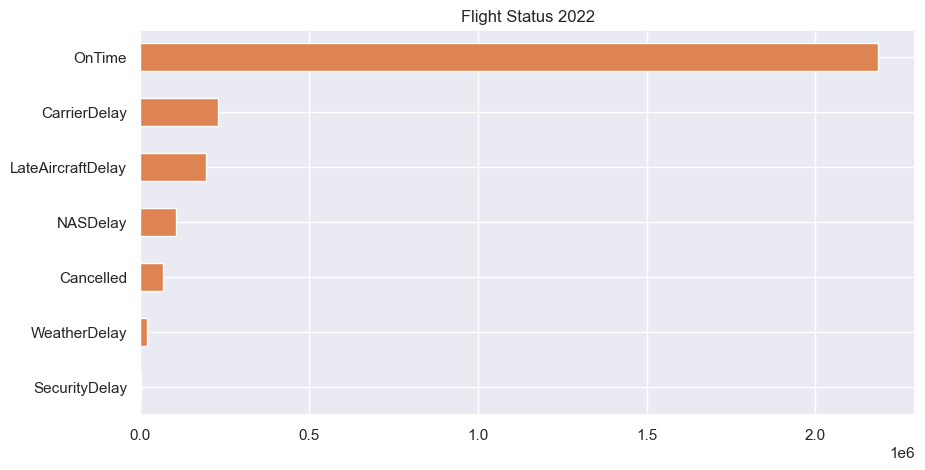

In [29]:
(df_flights
 .FlightStatus
 .value_counts(ascending=True)
 .plot(kind='barh', figsize=(10,5), color=current_palette[1], title="Flight Status 2022")
 )
plt.show()

## Percentage of Flight results by Year

In [30]:
df_agg = (df_flights
 .groupby([df_flights["FlightDate"].dt.year, "Operating_Airline"])
 [["FlightStatus"]]
 .value_counts()
 .unstack()
 )
df_agg.style.background_gradient(cmap="Greens")

In [31]:
df_agg = (df_flights
 .groupby([df_flights["FlightDate"].dt.month, "Operating_Airline"])
 [["FlightStatus"]]
 .value_counts()
 .unstack()
 )
df_agg.style.background_gradient(cmap="Greens")

In [32]:
#df_flights.loc[df_flights["ArrTime"] == 0]

In [33]:
(df_flights["FlightStatus"].value_counts())/df_flights.shape[0]

OnTime               0.779752
CarrierDelay         0.081890
LateAircraftDelay    0.069241
NASDelay             0.037951
Cancelled            0.023764
WeatherDelay         0.006877
SecurityDelay        0.000524
Name: FlightStatus, dtype: float64

In [34]:
df_flights["FlightStatus"].value_counts()

OnTime               2185620
CarrierDelay          229536
LateAircraftDelay     194080
NASDelay              106374
Cancelled              66611
WeatherDelay           19277
SecurityDelay           1469
Name: FlightStatus, dtype: int64

In [35]:
df_flights.columns.to_list()

['FlightDate',
 'Operating_Airline',
 'Tail_Number',
 'Flight_Number',
 'OriginAirportID',
 'Origin',
 'OriginCityName',
 'OriginState',
 'OriginStateName',
 'DestAirportID',
 'Dest',
 'DestCityName',
 'DestState',
 'DestStateName',
 'CRSDepTime',
 'DepTime',
 'DepDelay',
 'DepDel15',
 'DepDelayMinutes',
 'DepTimeBlk',
 'TaxiOut',
 'WheelsOn',
 'TaxiIn',
 'CRSArrTime',
 'ArrTime',
 'ArrDelayMinutes',
 'ArrDel15',
 'ArrTimeBlk',
 'Cancelled',
 'CancellationCode',
 'Diverted',
 'CRSElapsedTime',
 'AirTime',
 'Distance',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay',
 'FirstDepTime',
 'TotalAddGTime',
 'latitude',
 'longitude',
 'DepDelayClass',
 'Year',
 'Month',
 'FlightStatus']

In [36]:
df_flights.head()

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,latitude,longitude,DepDelayClass,Year,Month,FlightStatus
0,2022-04-05,American Airlines Inc.,N942AN,2700,11057,CLT,"Charlotte, NC",NC,North Carolina,13303,MIA,"Miami, FL",FL,Florida,1809,1829.0,20.0,1.0,20.0,1800-1859,24.0,2040.0,38.0,2015,2118.0,63.0,1.0,2000-2059,False,none,False,126.0,107.0,650.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,35.214011,-80.943126,Delay15_45,2022,4,NASDelay
1,2022-04-06,American Airlines Inc.,N303RE,2700,11057,CLT,"Charlotte, NC",NC,North Carolina,13303,MIA,"Miami, FL",FL,Florida,1809,2026.0,137.0,1.0,137.0,1800-1859,25.0,2224.0,9.0,2015,2232.0,138.0,1.0,2000-2059,False,none,False,126.0,93.0,650.0,7.0,0.0,1.0,0.0,130.0,0.0,0.0,35.214011,-80.943126,Delay45_180,2022,4,LateAircraftDelay
2,2022-04-07,American Airlines Inc.,N857NN,2700,11057,CLT,"Charlotte, NC",NC,North Carolina,13303,MIA,"Miami, FL",FL,Florida,1809,1916.0,67.0,1.0,67.0,1800-1859,25.0,2120.0,14.0,2015,2136.0,80.0,1.0,2000-2059,False,none,False,126.0,100.0,650.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,35.214011,-80.943126,Delay45_180,2022,4,NASDelay
3,2022-04-08,American Airlines Inc.,N865NN,2700,11057,CLT,"Charlotte, NC",NC,North Carolina,13303,MIA,"Miami, FL",FL,Florida,1809,1806.0,-3.0,0.0,0.0,1800-1859,18.0,2005.0,19.0,2015,2024.0,9.0,0.0,2000-2059,False,none,False,126.0,101.0,650.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.214011,-80.943126,OnTime,2022,4,OnTime
4,2022-04-09,American Airlines Inc.,N306PB,2700,11057,CLT,"Charlotte, NC",NC,North Carolina,13303,MIA,"Miami, FL",FL,Florida,1809,1804.0,-5.0,0.0,0.0,1800-1859,27.0,2006.0,8.0,2015,2014.0,0.0,0.0,2000-2059,False,none,False,126.0,95.0,650.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.214011,-80.943126,OnTime,2022,4,OnTime


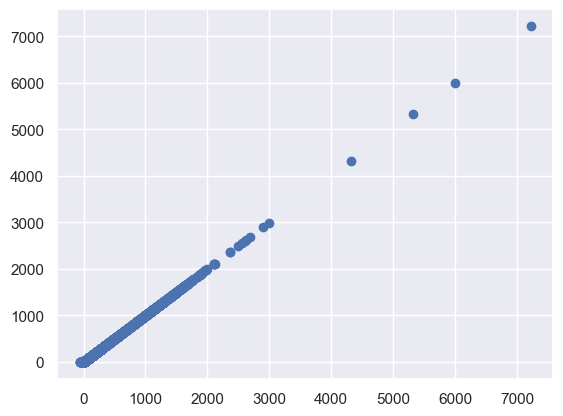

In [37]:
plt.scatter(df_flights["DepDelay"], df_flights["DepDelayMinutes"])

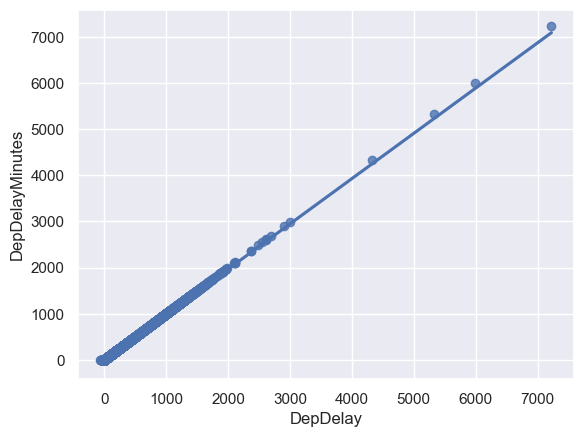

In [38]:
sns.regplot(x="DepDelay", y="DepDelayMinutes", data=df_flights)
plt.show()

In [39]:
(df_flights
 [["FlightStatus"]]
 .value_counts()
 .sort_values(ascending=False)
 .to_frame("Row Count")
 )

,Row Count
FlightStatus,
OnTime,2185620
CarrierDelay,229536
LateAircraftDelay,194080
NASDelay,106374
Cancelled,66611
WeatherDelay,19277
SecurityDelay,1469


#### Correlation [Pearson]

In [40]:
corr = (df_flights
        .select_dtypes('float16')
        .corr())
corr.style.background_gradient(cmap='coolwarm')


,DepTime,DepDelay,DepDel15,DepDelayMinutes,TaxiOut,WheelsOn,TaxiIn,ArrTime,ArrDelayMinutes,ArrDel15,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime
DepTime,1.000000,0.138096,0.262562,0.132995,0.142661,0.664375,0.051275,0.632638,0.124780,0.237767,-0.006530,0.075363,-0.002766,0.036385,0.031680,0.064022,0.003923,0.131063,0.043640,0.028872
DepDelay,0.138096,1.000000,0.543859,0.998127,0.045087,0.033749,0.014565,0.026557,0.973787,0.507356,0.025839,0.029312,0.023443,0.735221,0.267004,0.251975,0.038796,0.588508,0.198381,0.194494
DepDel15,0.262562,0.543859,1.000000,0.525988,0.054493,0.122610,0.003017,0.110283,0.483236,0.755859,0.033717,0.049272,0.035636,0.282585,0.116180,0.169218,0.029284,0.377823,0.132476,0.100960
DepDelayMinutes,0.132995,0.998127,0.525988,1.000000,0.047220,0.031474,0.019657,0.024772,0.976693,0.492686,0.020723,0.026041,0.017773,0.740268,0.268480,0.250434,0.038635,0.588415,0.198061,0.195058
TaxiOut,0.142661,0.045087,0.054493,0.047220,1.000000,0.163141,0.062901,0.158949,0.143719,0.227968,0.094437,0.128606,0.056288,0.037656,0.043969,0.281371,0.002782,0.033773,0.018020,0.017365
WheelsOn,0.664375,0.033749,0.122610,0.031474,0.163141,1.000000,0.091056,0.963651,0.039157,0.122764,0.014171,0.100447,0.009602,-0.001062,0.015157,0.056308,0.002526,0.030215,-0.008754,-0.021258
TaxiIn,0.051275,0.014565,0.003017,0.019657,0.062901,0.091056,1.000000,0.090810,0.093206,0.147380,0.098938,0.119535,0.074991,0.013033,0.019710,0.219836,0.000814,0.019653,-0.001438,-0.004211
ArrTime,0.632638,0.026557,0.110283,0.024772,0.158949,0.963651,0.090810,1.000000,0.032434,0.111625,0.011502,0.097046,0.006344,-0.002868,0.014161,0.051939,0.002344,0.023288,-0.011068,-0.022248
ArrDelayMinutes,0.124780,0.973787,0.483236,0.976693,0.143719,0.039157,0.093206,0.032434,1.000000,0.526547,0.014414,0.033756,0.012187,0.739362,0.276720,0.333331,0.039036,0.583010,0.186229,0.182384
ArrDel15,0.237767,0.507356,0.755859,0.492686,0.227968,0.122764,0.147380,0.111625,0.526547,1.000000,0.023821,0.065683,0.026926,0.296885,0.119615,0.308635,0.031201,0.385621,0.114412,0.082304


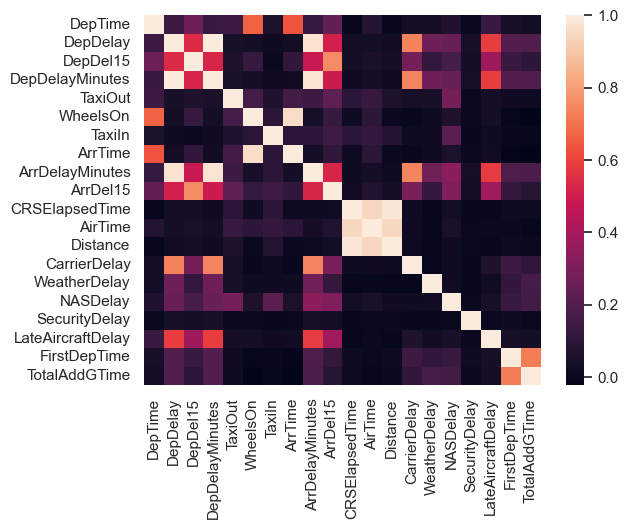

In [41]:
sns.heatmap(
    (df_flights
     .select_dtypes('float16')
     .corr()))
plt.show()


<AxesSubplot: xlabel='FlightDate'>

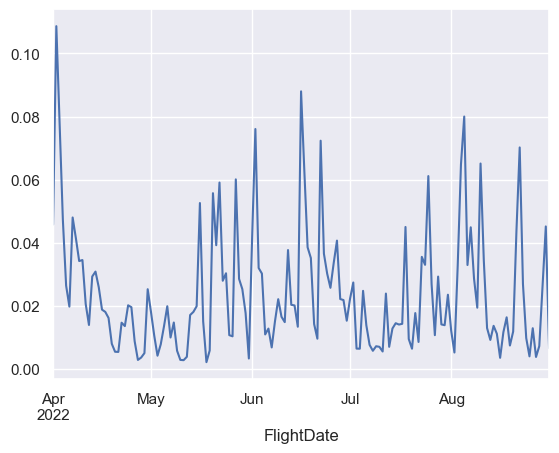

In [42]:
(df_flights.
 groupby("FlightDate")
 ["Cancelled"]
 .agg("mean")
 .plot()
 )


<AxesSubplot: xlabel='FlightDate'>

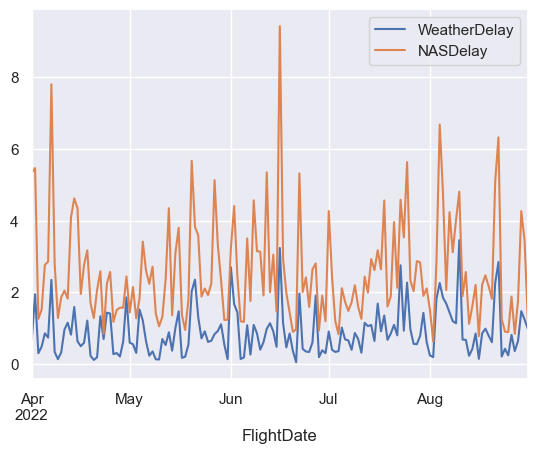

In [43]:
(df_flights.
 groupby("FlightDate")
 [["WeatherDelay", "NASDelay"]]
 .agg("mean")
 .plot())


<AxesSubplot: xlabel='FlightDate'>

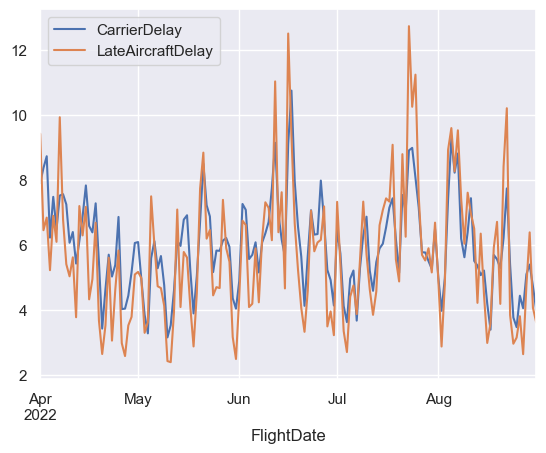

In [44]:
(df_flights.
 groupby("FlightDate")
 [["CarrierDelay", "LateAircraftDelay"]]
 .agg("mean")
 .plot())


##### Frequency Distribution Table

In [45]:
(df_flights
 [["Operating_Airline"]]
 .value_counts()
 .sort_values(ascending=False)
 .to_frame("Row Count")
 )


,Row Count
Operating_Airline,
Southwest Airlines Co.,455762
Delta Air Lines Inc.,383703
SkyWest Airlines Inc.,325484
American Airlines Inc.,319295
United Air Lines Inc.,266431
JetBlue Airways,115033
Republic Airlines,112610
Envoy Air,107146
Alaska Airlines Inc.,98733


In [46]:
px.bar(
    df_flights["Operating_Airline"]
    .value_counts()
    .sort_values(ascending=True),
    orientation='h',
    template="plotly_dark",
    title="Flights per airline",
    height=700,
)


In [47]:
df_flights.head(3)

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,latitude,longitude,DepDelayClass,Year,Month,FlightStatus
0,2022-04-05,American Airlines Inc.,N942AN,2700,11057,CLT,"Charlotte, NC",NC,North Carolina,13303,MIA,"Miami, FL",FL,Florida,1809,1829.0,20.0,1.0,20.0,1800-1859,24.0,2040.0,38.0,2015,2118.0,63.0,1.0,2000-2059,False,none,False,126.0,107.0,650.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,35.214011,-80.943126,Delay15_45,2022,4,NASDelay
1,2022-04-06,American Airlines Inc.,N303RE,2700,11057,CLT,"Charlotte, NC",NC,North Carolina,13303,MIA,"Miami, FL",FL,Florida,1809,2026.0,137.0,1.0,137.0,1800-1859,25.0,2224.0,9.0,2015,2232.0,138.0,1.0,2000-2059,False,none,False,126.0,93.0,650.0,7.0,0.0,1.0,0.0,130.0,0.0,0.0,35.214011,-80.943126,Delay45_180,2022,4,LateAircraftDelay
2,2022-04-07,American Airlines Inc.,N857NN,2700,11057,CLT,"Charlotte, NC",NC,North Carolina,13303,MIA,"Miami, FL",FL,Florida,1809,1916.0,67.0,1.0,67.0,1800-1859,25.0,2120.0,14.0,2015,2136.0,80.0,1.0,2000-2059,False,none,False,126.0,100.0,650.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,35.214011,-80.943126,Delay45_180,2022,4,NASDelay


In [48]:
(df_flights.
 groupby(["Flight_Number", "Tail_Number", "OriginCityName","DestCityName" ])
[["DepDelayMinutes"]]
#.agg(["mean", "sum"]).head(20)
)


In [49]:
cols = ["FlightDate","Tail_Number","Flight_Number","Operating_Airline", "OriginCityName","DestCityName", "CRSDepTime", "DepTime","DepDelayMinutes","AirTime", "FlightStatus"]
(df_flights
 .loc[df_flights["DepDelayMinutes"] >10, cols ]
 .sort_values(by=["Flight_Number", "FlightDate", "CRSDepTime"],ascending=[True, True, True]))

,FlightDate,Tail_Number,Flight_Number,Operating_Airline,OriginCityName,DestCityName,CRSDepTime,DepTime,DepDelayMinutes,AirTime,FlightStatus
63412,2022-04-03,N807JB,1,JetBlue Airways,"New York, NY","Fort Lauderdale, FL",559,610.0,11.0,148.0,OnTime
26395,2022-04-03,N528AS,1,Alaska Airlines Inc.,"Washington, DC","Seattle, WA",800,853.0,53.0,321.0,CarrierDelay
192273,2022-04-03,N661NK,1,Spirit Air Lines,"Fort Lauderdale, FL","Chicago, IL",2147,211.0,264.0,163.0,CarrierDelay
192274,2022-04-04,N680NK,1,Spirit Air Lines,"Fort Lauderdale, FL","Chicago, IL",2147,2228.0,40.0,157.0,CarrierDelay
192275,2022-04-05,N681NK,1,Spirit Air Lines,"Fort Lauderdale, FL","Chicago, IL",2200,2252.0,52.0,164.0,CarrierDelay
192276,2022-04-06,N661NK,1,Spirit Air Lines,"Fort Lauderdale, FL","Chicago, IL",2200,2236.0,35.0,170.0,NASDelay
63415,2022-04-07,N807JB,1,JetBlue Airways,"New York, NY","Fort Lauderdale, FL",555,617.0,22.0,168.0,CarrierDelay
192278,2022-04-08,N668NK,1,Spirit Air Lines,"Fort Lauderdale, FL","Chicago, IL",2200,2356.0,117.0,153.0,LateAircraftDelay
58200,2022-04-09,N607JB,1,JetBlue Airways,"New York, NY","Fort Lauderdale, FL",559,647.0,48.0,168.0,CarrierDelay
192280,2022-04-10,N671NK,1,Spirit Air Lines,"Fort Lauderdale, FL","Chicago, IL",2200,2256.0,57.0,160.0,LateAircraftDelay


In [50]:
cols = ["FlightDate","Tail_Number","Flight_Number","Operating_Airline", "OriginCityName","DestCityName", "CRSDepTime", "DepTime","DepDelayMinutes","AirTime", "FlightStatus"]
(df_flights[cols]
 .groupby(["Flight_Number", "Operating_Airline"])
 [["DepDelayMinutes"]]
 .mean())

DepDelayMinutes
Flight_Number Operating_Airline                                         
1             Air Wisconsin Airlines Corp                            NaN
              Alaska Airlines Inc.                              6.934640
              Allegiant Air                                    20.928572
              American Airlines Inc.                            8.569106
              Capital Cargo International                            NaN
              Comair Inc.                                            NaN
              Commutair Aka Champlain Enterprises, Inc.              NaN
              Delta Air Lines Inc.                                   NaN
              Endeavor Air Inc.                                      NaN
              Envoy Air                                              NaN
...                                                                  ...
9679          GoJet Airlines, LLC d/b/a United Express               NaN
              Hawaiian Airlines Inc.                                 NaN
              Horizon Air                                            NaN
              JetBlue Airways                                        NaN
              Mesa Airlines Inc.                                     NaN
              Republic Airlines                              1603.000000
              SkyWest Airlines Inc.                                  NaN
              Southwest Airlines Co.                                 NaN
              Spirit Air Lines                                       NaN
              United Air Lines Inc.                                  NaN

[141330 rows x 1 columns]

In [51]:
col2 = ["CarrierDelay","WeatherDelay",	"NASDelay",	"SecurityDelay","LateAircraftDelay", "FirstDepTime", "TotalAddGTime", "latitude", "longitude", "DepDelayClass"]
cols = ["FlightDate","CRSDepTime", "DepTime","DepDelayMinutes","AirTime", "FlightStatus"]	